# Handwritten english text recognition

In this tutorial we implement [handwritten-english-recognition-0001](https://github.com/openvinotoolkit/open_model_zoo/tree/master/models/intel/handwritten-english-recognition-0001) model. Following model is used to recognize english text from a piece of handwriting. Main steps covered in the notebook
- Download the xml file of pre-trined model using omz-downloader tool.
- Load the model with required precision and get the shape for input and output layer
- Resize the input image(handwriting) into the input shape of the model and feed the input to model
- Decode the result obtained from the model.

In [1]:
!pip install openvino-dev

     |████████████████████████████████| 5.8 MB 4.8 MB/s 
     |████████████████████████████████| 1.2 MB 37.1 MB/s 
     |████████████████████████████████| 99 kB 9.7 MB/s 
     |████████████████████████████████| 4.0 MB 30.9 MB/s 
     |████████████████████████████████| 26.1 MB 1.8 MB/s 
     |████████████████████████████████| 298 kB 26.5 MB/s 
     |████████████████████████████████| 596 kB 43.7 MB/s 
     |████████████████████████████████| 3.3 MB 33.0 MB/s 
     |████████████████████████████████| 22.3 MB 1.4 MB/s 
     |████████████████████████████████| 14.1 MB 25.0 MB/s 
     |████████████████████████████████| 517 kB 46.0 MB/s 
     |████████████████████████████████| 1.9 MB 31.6 MB/s 
     |████████████████████████████████| 15.7 MB 159 kB/s 
     |████████████████████████████████| 9.5 MB 34.5 MB/s 
     |████████████████████████████████| 63 kB 1.2 MB/s 
     |████████████████████████████████| 14.8 MB 39.1 MB/s 
     |████████████████████████████████| 25.9 MB 1.6 MB/s 
     |███████████

In [2]:
#Importing dependencies
from openvino.runtime import Core

from itertools import groupby      
from pathlib import Path

import cv2                         
import numpy as np
import matplotlib.pyplot as plt

## Download the pre-trained model

In [3]:
MODEL_NAME= 'handwritten-english-recognition-0001' #Name of the model to be downloaded
MODEL_FOLDER = 'model'                             #Name of the folder where model is to be downloaded 
PRECISION= 'FP32'                                 

Command to download the pre-trained model using omz_downloader tool provided by open vino

In [4]:
! omz_downloader --name  {MODEL_NAME} --output_dir {MODEL_FOLDER} --precision {PRECISION}

################|| Downloading handwritten-english-recognition-0001 ||################

========== Downloading model/intel/handwritten-english-recognition-0001/FP32/handwritten-english-recognition-0001.xml
... 100%, 103 KB, 662 KB/s, 0 seconds passed

========== Downloading model/intel/handwritten-english-recognition-0001/FP32/handwritten-english-recognition-0001.bin
... 100%, 21704 KB, 24521 KB/s, 0 seconds passed



## Loading the model

In [5]:
MODEL_PATH= Path(f'/content/{MODEL_FOLDER}/intel/{MODEL_NAME}/{PRECISION}/{MODEL_NAME}.xml')
DEVICE= 'CPU'

In [6]:
core = Core()
model = core.read_model(model=MODEL_PATH)
compiled_model = core.compile_model(model=model, device_name=DEVICE )
input_layer=compiled_model.input(0)
output_layer=compiled_model.output(0)

#Printing the shape of input and output layer of the model
print('Input layer shape of the model: {input_layer}'.format(input_layer=input_layer))
print('Output layer shape of the model: {output_layer}'.format(output_layer=output_layer))

Input layer shape of the model: <ConstOutput: names[actual_input] shape{1,1,96,2000} type: f32>
Output layer shape of the model: <ConstOutput: names[output] shape{250,1,95} type: f32>


## Pre-processing the input image

In [7]:
def preprocess_image(image):
  
  image_height, image_width = image.shape # Shape of image
  B, C, H, W = input_layer.shape          # B: Batch size, C: Channels, H: Height, W: Width
  scale_ratio=H/image_height              # scale ratio between input shape height and image height
  resized_image = cv2.resize(image, None, fx=scale_ratio, fy=scale_ratio, interpolation=cv2.INTER_AREA)   #Resizing the image
  resized_image = np.pad(resized_image, ((0, 0), (0, W - resized_image.shape[1])), mode="edge")           #Padding image to match input shape

  input_image = resized_image[None, None, :, :]  #Reshape image to input layer
  return input_image,resized_image

## Inference

In [8]:
IMAGE_PATH='/content/data/handwriting.jpg'
image = cv2.imread(filename=IMAGE_PATH, flags=cv2.IMREAD_GRAYSCALE) #Reading the image
input_image,resized_image = preprocess_image(image)                 
out = compiled_model([input_image])[output_layer]                   #Inference from compiled model

## Decoding the result

The following model predicts symbol from 95 labels taken from [GNHK](https://webflow.goodnotes.com/gnhk) dataset.

In [9]:
#Reading the charlist and storing it in a string.
CHAR_LIST='/content/data/charlist.txt'
blank_char=''
with open(CHAR_LIST, "r", encoding="utf-8") as charlist:
    letters = blank_char + "".join(line.strip() for line in charlist)

In [10]:
out = np.squeeze(out)  # Discarding the batch dimension
predictions_indexes = np.argmax(out, axis=1)  #Picking out symbol with highest probability

output_text_indexes = list(groupby(predictions_indexes)) #Removing concurrent letters
output_text_indexes, _ = np.transpose(output_text_indexes, (1, 0)) #Removing grouper objects

output_text_indexes = output_text_indexes[output_text_indexes != 0] #Removing blank symbols
output_text = [letters[letter_index] for letter_index in output_text_indexes] #Assign letters from maximum probabilty symbols with the help of letters string

#Storing final output
text_final = ''
for i in output_text:
  text_final+=i

## Final Results

helle from a student


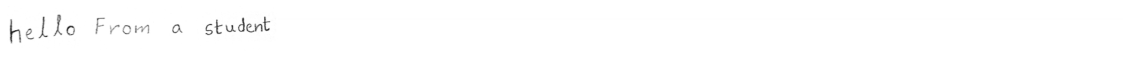

In [11]:
#Plotting the handwriting image
plt.figure(figsize=(20, 1))
plt.axis("off")
plt.imshow(resized_image, cmap="gray", vmin=0, vmax=255)

#Printing the decoded result
print(text_final) 